# Нейронные сети. Введение в PyTorch

## PyTorch

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

In [1]:
import numpy as np
import torch
print(torch.__version__)

1.8.0+cu111


* изначально вообще был фреймворк torch, написанный на Lua
* а приставка Py как раз означает, что его перевели на Python

## NumPy and PyTorch

* вообще на некотором уровне работа с PyTorch очень похожа на работу с numpy

In [ ]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n%s\n" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s\n" % (x + 5))
print("X*X^T  :\n%s\n" % np.dot(x, x.T))
print("mean over cols :\n%s\n" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s\n" % (np.cumsum(x, axis=0)))

In [2]:
# PyTorch world

x = np.arange(16).reshape(4, 4)

x = torch.tensor(x, dtype=torch.float32)  # or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n%s" % torch.matmul(x, x.transpose(1, 0)))  # short: x.mm(x.t())
print("mean over cols :\n%s" % torch.mean(x, dim=-1))
print("cumsum of cols :\n%s" % torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
X.shape : torch.Size([4, 4])

add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


__Задание 1. Polar Pretzels (0.5 балла)__:
_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

Есть в тригонометрии класс функций с забавными графиками. Вот пример:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$

Реализуйте вычисление этой функции на PyTorch.

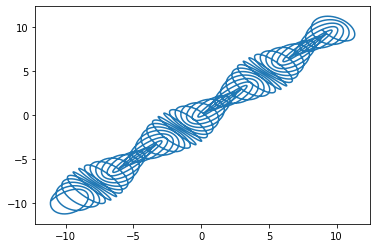

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

t = torch.linspace(-10, 10, steps=10000)

# compute x(t) and y(t) as defined above
x = t - 1.5 * torch.cos(15 * t)
y = t - 1.5 * torch.sin(16 * t)

plt.plot(x.numpy(), y.numpy())

## Автоматический подсчёт градиентов

* казалось бы, а какие вообще плюсы в PyTorch?
* он считает градиент за вас!
* ни один уважающий себя фрейморк про нейросети не может обойтись без автоматического backprop

PyTorch вычисляет градиенты следующим образом:
* при создании тензора ему выставляется параметр `requires_grad`:
    * ```torch.zeros(5, requires_grad=True)```
    * ```torch.tensor(np.arange(5), dtype=torch.float32, requires_grad=True)```
* определяем что-нибудь дифференцируемое `loss = arbitrary_function(a)`
* вызываем `loss.backward()`
* градиенты доступны по ```a.grads```

Пример: обучим линейную регрессию на датасете с ценами на дома в Бостоне

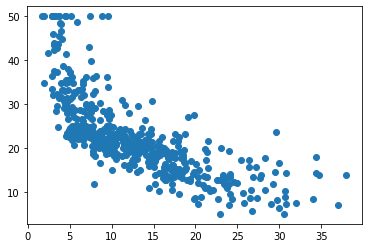

In [5]:
%matplotlib inline
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt

boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target)
plt.show()

In [6]:
from torch.autograd import Variable

w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

In [7]:
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

# propagete gradients
loss.backward()

Градиенты сохранены в `.grad` у переменных:

In [8]:
print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

dL/dw = 
 tensor([-47.3514])
dL/db = 
 tensor([-45.0656])


Если вы считаете градиент для нескольких функций потерь, в переменных градиенты складываются, так что между итерациями вычислений **надо его обнулять**

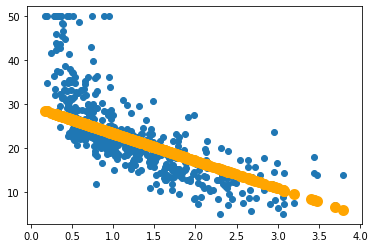

loss =  44.59417


In [9]:
from IPython.display import clear_output

for i in range(100):

    y_pred = w * x + b
    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()
    

    if (i+1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.5:
            print("Done!")
            break

## Идём на уровень выше

* конечно же постоянно задавать руками все функции потерь и слои для нейросети очень муторно и сложно
* но конечно же специально для нас высокоуровнево реализованы слои, функции активации и алгоритмы обучения сети

Давайте рассмотрим это на примере классификации букв на "*A*" vs "*B*" (чтобы не скатываться к совсем классической классификации цифр на [MNIST](https://en.wikipedia.org/wiki/MNIST_database)):

In [10]:
import os
from glob import glob

import numpy as np
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split


def load_notmnist(path='./notMNIST_small', letters='ABCDEFGHIJ',
                  img_shape=(28, 28), test_size=0.25, one_hot=False):
    # download data if it's missing. If you have any problems, go to the urls
    # and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system(
            'wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system(
            'tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0

    data, labels = [], []
    print("Parsing...")
    for img_path in glob(os.path.join(path, '*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters:
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except BaseException:
            print(
                "found broken img: %s [it's ok if <10 images are broken]" %
                img_path)

    data = np.stack(data)[:, None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    # convert classes to ints
    letter_to_i = {l: i for i, l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))

    if one_hot:
        labels = (np.arange(np.max(labels) + 1)
                  [None, :] == labels[:, None]).astype('float32')

    # split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_size, random_state=42)

    print("Done")
    return X_train, y_train, X_test, y_test

In [65]:
X_train, y_train, X_test, y_test = load_notmnist(letters='AB')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print("Train size = %i, test_size = %i" % (len(X_train), len(X_test)))

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done
Train size = 2808, test_size = 937


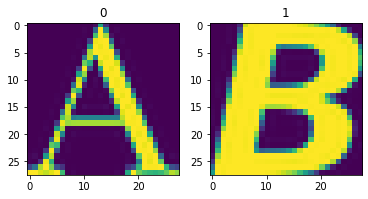

In [66]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

`nn.Module` - это базовый класс для всех слоёв нейронной сети

In [67]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    :ivar training: Boolean represents whether this module is in training or
                    evaluation mode.
    :vartype training: bool
    


Для начала обучим для этой задачи логистическую регрессию (это ведь тоже нейронная сеть):
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


In [68]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(784, 1))

model.add_module('l2', nn.Sigmoid())

In [69]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 784]), torch.Size([1])]


In [70]:
x = torch.tensor(X_train[:3], dtype=torch.float32)
y = torch.tensor(y_train[:3], dtype=torch.float32)

y_predicted = model(x)
print(y_predicted.shape)
y_predicted = y_predicted[:, 0]
print(y_predicted.shape)

torch.Size([3, 1])
torch.Size([3])


Давайте зададим функцию потерь как logloss:
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i=1 | X_i) + (1-y_i) \cdot log (1-P(y_i=1 | X_i)) ]$$



In [24]:
crossentropy = y * torch.log(y_predicted) + (1 - y) * torch.log(1 - y_predicted)
loss = -torch.mean(crossentropy)

assert tuple(crossentropy.size()) == (
    3,), "Crossentropy must be a vector with element per sample"
assert tuple(loss.size()) == tuple(
), "Loss must be scalar. Did you forget the mean/sum?"
assert loss.data.numpy() > 0, "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy() <= np.log(
    3), "Loss is too large even for untrained model. Please double-check it."

* PyTorch также предоставляет вам и набор оптимизаторов!

In [25]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)

loss.backward()      # add new gradients
opt.step()           # change weights
opt.zero_grad()      # clear gradients

In [26]:
del x, y, y_predicted, loss, y_pred

### И снова всё вместе!

In [27]:
model = nn.Sequential()
model.add_module('first', nn.Linear(784, 1))
model.add_module('second', nn.Sigmoid())

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
history = []

for i in range(100):

    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    # predict probabilities
    y_predicted = model(x_batch)[:, 0]

    assert y_predicted.dim(
    ) == 1, "did you forget to select first column with [:, 0]"

    # compute loss
    loss = -torch.mean(y_batch * torch.log(y_predicted) + (1 - y_batch) * torch.log(1 - y_predicted))

    loss.backward()      # add new gradients
    opt.step()           # change weights
    opt.zero_grad()      # clear gradients

    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.972
step #10 | mean loss = 0.524
step #20 | mean loss = 0.275
step #30 | mean loss = 0.193
step #40 | mean loss = 0.170
step #50 | mean loss = 0.146
step #60 | mean loss = 0.135
step #70 | mean loss = 0.130
step #80 | mean loss = 0.111
step #90 | mean loss = 0.106


Давайте оценим качество нашей модели:

In [29]:
# use your model to predict classes (0 or 1) for all test samples
predicted_y_test = model(torch.tensor(X_test))[:, 0].data.numpy() > 0.5

assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(
    predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(predicted_y_test == y_test)

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

Test accuracy: 0.95304


## Ещё больше про PyTorch:
* [PyTorch на GPU](http://pytorch.org/docs/master/notes/cuda.html)
* [туториалы на официальном сайте](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [примеры реализаций крутых моделей на PyTorch](https://github.com/pytorch/examples)
* [и ещё немного крутых моделей!](https://github.com/spro/practical-pytorch)
* [и ещё!](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)

**Задача 3 (2.5 балла)**. Реализуйте нейронную сеть для задачи отличия букв, но немного более сложной:
* 10 различных букв
* 20k примеров

Достичь нужно минимум 80% точности с как минимум двумя слоями в ней.
С 10 классами нужно использовать __Softmax__ в самом конце вместо сигмоиды и минимизировать __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)).  Напишите свою функцию потерь либо используйте `torch.nn.functional.nll_loss`.

In [168]:
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


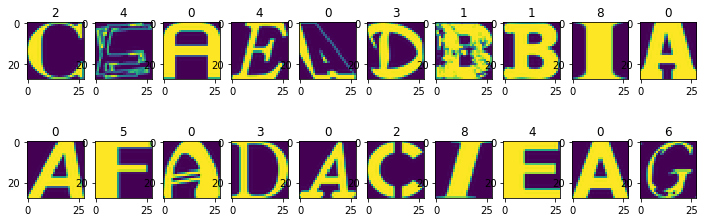

In [169]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [170]:
model = nn.Sequential()
model.add_module('first', nn.Linear(784, 128))
model.add_module('second', nn.Sigmoid())
model.add_module('third', nn.Linear(128, 10))
model.add_module('fourth', nn.LogSoftmax())

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [171]:
print("Train size = %i, test_size = %i" % (len(X_train), len(X_test)))

Train size = 14043, test_size = 4681


In [172]:
history = []

for i in range(1000):

    ix = np.random.randint(0, len(X_train), 2560)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.long)

    y_predicted = model(x_batch)

    loss = torch.nn.functional.nll_loss(y_predicted, y_batch)

    loss.backward()      # add new gradients
    opt.step()           # change weights
    opt.zero_grad()      # clear gradients

    history.append(loss.data.numpy())

    if i % 100 == 0:
        print("step #%i | loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | loss = 2.346
step #100 | loss = 0.434
step #200 | loss = 0.330
step #300 | loss = 0.274
step #400 | loss = 0.239
step #500 | loss = 0.200
step #600 | loss = 0.165
step #700 | loss = 0.147
step #800 | loss = 0.131
step #900 | loss = 0.103


In [173]:
predicted_y_test = model(torch.tensor(X_test))
indexes = torch.argmax(predicted_y_test, dim=1)
for i in range(len(predicted_y_test)):
    predicted_y_test[i] = indexes[i]
    
predicted_y_test = predicted_y_test[:, 0].data.numpy()

assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(
    predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(predicted_y_test == y_test)

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.8, "try training longer"

Test accuracy: 0.91369
